In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%matplotlib inline

In [8]:
from tensorflow import keras
from tensorflow.keras import models, layers, callbacks, activations, optimizers

In [9]:
from data_4_models import data_arrays, input_shape_check

In [11]:
x_train, y_train, x_valid, y_valid, x_test, y_test, alphabet = data_arrays(data_path= '/home/pgarcia/rbp_project/data/HNRNPK_K562_200.h5')
print(x_train.shape, y_train.shape)

(4008, 200, 9) (4008, 1)


In [12]:
x_train, x_test, x_valid = input_shape_check(x_train, x_test,x_valid)

Input shape adjusted:
(4008, 200, 4)
(1146, 200, 4)
(572, 200, 4)


In [13]:
# Make an empty list that will contain index of all positive occurences in y_test
idx_ytest=[]

#use enumerate function to get index of positive signals in y_test
for i, entry in enumerate(y_test):
    if entry == 1:
        idx_ytest.append(i)

# Make an array from the list that contains all positive signals from y_test 
idx_ytest_array = np.array(idx_ytest)

# Get a random number from array by using numpy.random.choice()
random_num = np.random.choice(idx_ytest_array)

print(random_num)

991


# DeepBind Model

In [24]:
# load model
model = tf.keras.models.load_model('/home/pgarcia/rbp_project/models_deepbind3/deepbind + HNRNPK_K562_200.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 16)           1552      
                                                                 
 activation (Activation)     (None, 200, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 16)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

(1, 200, 4)
tf.Tensor(
[[[-1.79760121e-02 -1.67161282e-02 -9.92466137e-02  3.45953479e-02]
  [-3.62948477e-02 -1.85382143e-02 -1.05513567e-02  4.92247902e-02]
  [-2.64689531e-02  3.65947792e-03 -4.12898557e-03  1.94952462e-03]
  [-5.24270199e-02 -6.12321198e-02  5.49030341e-02 -2.44962964e-02]
  [-8.58336166e-02 -5.43854125e-02  2.94447299e-02  3.27502377e-02]
  [ 5.11629432e-02 -5.19047566e-02  1.40663674e-02 -9.92121249e-02]
  [-1.99880283e-02 -1.12883054e-01  5.86856008e-02  2.07120888e-02]
  [-8.59906971e-02  3.28198634e-03 -1.92248188e-02  8.02172348e-02]
  [-1.56383254e-02 -1.27378687e-01  3.15489210e-02  8.21563452e-02]
  [-1.98338591e-02  2.24211272e-02  3.22476700e-02  1.09496117e-02]
  [-1.42722413e-01  3.93681154e-02  1.14426896e-01 -1.77414939e-02]
  [-7.51099586e-02 -1.97708569e-02  2.72789644e-03 -1.65519044e-02]
  [ 2.04446673e-01 -3.28292698e-01 -2.04848647e-01  1.43635780e-01]
  [-3.83773595e-01 -1.03375129e-01 -1.62702724e-01  1.98901698e-01]
  [-2.85743058e-01  2.414

/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7fb4080184c0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7fb4f51e2520>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f

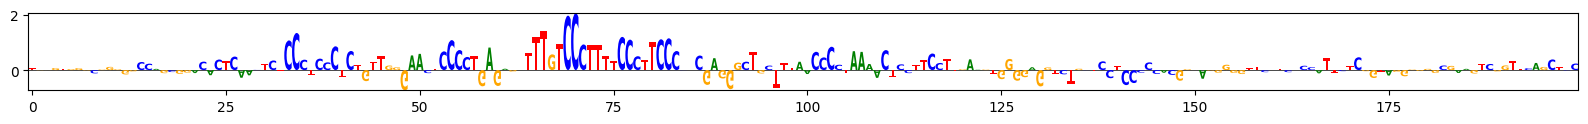

In [25]:
# get the pre-activated outputs
layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract a sequence from x_test
X = x_test[991:992]
print(X.shape)

#########################################################
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

# calculate saliency maps
saliency_map = calculate_saliency_map(X, layer)
print(saliency_map)
saliency_map = saliency_map.numpy()
# gradient correction
saliency_map -= np.mean(saliency_map, axis=2, keepdims=True)

#########################################################
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)
  
  # Save the saliency plot with the sequence index in the filename
  fig.savefig(f"HNRNPK_sal_map_seq991_deepbind.svg", dpi=300)

# DeepBind_exp Model

In [17]:
# load model
model = tf.keras.models.load_model('/home/pgarcia/rbp_project/models_deepbind3/deepbind_exp + HNRNPK_K562_200.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 16)           1552      
                                                                 
 activation (Activation)     (None, 200, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 16)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

(1, 200, 4)
tf.Tensor(
[[[-1.31876498e-01 -2.08519902e-02  1.51280418e-01 -1.34396683e-02]
  [-6.72873575e-03  3.48917171e-02  2.51314268e-02  3.36630689e-03]
  [ 4.15224023e-02  8.00876170e-02 -5.01791500e-02 -4.68823723e-02]
  [ 2.93888282e-02 -8.72993246e-02  1.66388944e-01 -1.49600450e-02]
  [-1.92933902e-01  2.95071080e-02  9.22318995e-02 -3.45332585e-02]
  [-2.17472725e-02 -5.25576714e-03 -2.15757247e-02  5.08946106e-02]
  [ 9.64811165e-03  6.13951944e-02 -2.22246349e-02 -3.98584157e-02]
  [-1.57742187e-01  2.13623047e-01 -2.27821358e-02  5.22197410e-02]
  [-3.72508094e-02 -8.41653571e-02  1.70898885e-02  1.00577943e-01]
  [ 9.02741700e-02  7.37944692e-02  8.20175558e-03 -4.34550904e-02]
  [-2.50945985e-01  1.80810452e-01 -2.12147422e-02 -2.55378839e-02]
  [ 1.74388755e-02  4.95302826e-02 -8.06451496e-03  1.21670246e-01]
  [-5.40243229e-03 -9.33103263e-02  4.26486619e-02  1.10964380e-01]
  [-7.92171210e-02  1.71364516e-01 -3.02453414e-02  1.00272000e-01]
  [-1.66632310e-01  8.485

/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7fb4f46f45e0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7fb4f46f4640>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f

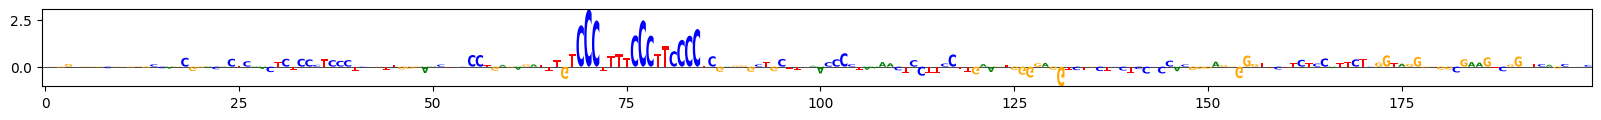

In [18]:
# get the pre-activated outputs
layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract a sequence from x_test
X = x_test[991:992]
print(X.shape)

#########################################################
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

# calculate saliency maps
saliency_map = calculate_saliency_map(X, layer)
print(saliency_map)
saliency_map = saliency_map.numpy()
# gradient correction
saliency_map -= np.mean(saliency_map, axis=2, keepdims=True)

#########################################################
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)
  
  # Save the saliency plot with the sequence index in the filename
  fig.savefig(f" HNRNPK_sal_map_seq991_deepbind_exp.svg", dpi=300)

# Baseline CNN Model

In [19]:
# load model
model = tf.keras.models.load_model('/home/pgarcia/rbp_project/models_deepbind3/baseline_cnn + HNRNPK_K562_200.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 30)           2310      
                                                                 
 activation (Activation)     (None, 200, 30)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 30)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 30)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 30)           17130     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2, 30)             0         
 g1D)                                                   

(1, 200, 4)
tf.Tensor(
[[[-2.96704881e-02 -1.72698200e-01  1.46107748e-01  6.18945137e-02]
  [-7.49648409e-03 -1.26265362e-01  2.10927010e-01 -3.81717324e-01]
  [-3.59927148e-01  8.32682922e-02  1.64604574e-01 -7.86178112e-01]
  [ 3.39504123e-01 -5.20556629e-01  1.57884747e-01 -5.05533457e-01]
  [-2.66165920e-02 -3.79923195e-01  4.24702764e-01 -3.60436261e-01]
  [-4.50242430e-01  3.40356305e-03  2.22276703e-01 -9.99997795e-01]
  [ 3.49600792e-01 -6.88455641e-01  1.87282905e-01 -1.40775815e-01]
  [-3.04685473e-01 -4.02075380e-01  5.27581930e-01  7.52747729e-02]
  [-4.45337057e-01  8.13775599e-01 -6.13129199e-01 -7.29090869e-01]
  [ 4.88712251e-01 -1.04503667e+00  2.93547094e-01 -7.37412751e-01]
  [ 4.33118492e-02  6.42253682e-02 -4.00272399e-01 -6.48671806e-01]
  [-4.94955361e-01 -5.67973144e-02  1.91775545e-01 -4.88183111e-01]
  [-6.59231305e-01 -2.41168857e-01 -1.14355780e-01  1.52829781e-01]
  [-2.87334263e-01 -1.06818095e-01  4.05167714e-02 -1.91720068e-01]
  [-5.54435372e-01  7.806

/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7fb4f43bcc40>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7fb4f43bcbb0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f

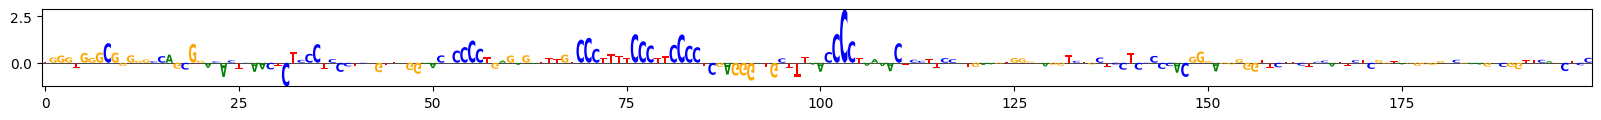

In [20]:
# get the pre-activated outputs
layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract a sequence from x_test
X = x_test[991:992]
print(X.shape)

#########################################################
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

# calculate saliency maps
saliency_map = calculate_saliency_map(X, layer)
print(saliency_map)
saliency_map = saliency_map.numpy()
# gradient correction
saliency_map -= np.mean(saliency_map, axis=2, keepdims=True)

#########################################################
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)
  
  # Save the saliency plot with the sequence index in the filename
  fig.savefig(f" HNRNPK_sal_map_seq991_baseline_cnn.svg", dpi=300)

# Baseline_CNN_exp Model

In [21]:
# load model
model = tf.keras.models.load_model('/home/pgarcia/rbp_project/models_deepbind3/baseline_cnn_exp + HNRNPK_K562_200.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 30)           2310      
                                                                 
 activation (Activation)     (None, 200, 30)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 30)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 30)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 30)           17130     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2, 30)             0         
 g1D)                                                   

(1, 200, 4)
tf.Tensor(
[[[-1.67064562e-01 -6.42489567e-02 -1.57226115e-01 -2.67276131e-02]
  [-2.53119022e-01 -2.11590752e-02  1.93814747e-04 -1.07692644e-01]
  [-3.13580573e-01 -8.83854032e-02  1.51168369e-02 -1.89973697e-01]
  [-1.40946597e-01 -1.47480473e-01  3.33153047e-02 -2.58585632e-01]
  [-1.55006602e-01 -1.97548032e-01  2.35796161e-02 -1.61309585e-01]
  [-3.12180102e-01 -1.34593844e-01  1.05512723e-01 -2.49256104e-01]
  [-3.58231157e-01 -1.73641555e-02 -4.58411612e-02 -2.75592983e-01]
  [-1.85065538e-01 -1.04032829e-01 -8.91741887e-02 -2.01666266e-01]
  [-1.68680876e-01  1.38453543e-02 -2.25493327e-01 -2.28829816e-01]
  [-1.98221713e-01 -4.64690290e-02 -6.57075197e-02 -2.37943694e-01]
  [-2.44882837e-01 -2.36974470e-02 -7.84856528e-02 -3.41155976e-01]
  [-1.32818997e-01 -6.09295294e-02 -7.24499859e-03 -2.26397917e-01]
  [-1.65936634e-01 -1.52546331e-01 -6.80070519e-02 -8.30421597e-02]
  [-1.91540748e-01 -6.04679510e-02  6.55733123e-02 -2.00595051e-01]
  [-1.16861776e-01 -6.884

/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7fb462343610>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7fb462343970>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  glyph_df.loc[p, c] = glyph
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<logomaker.src.Glyph.Glyph object at 0x7f

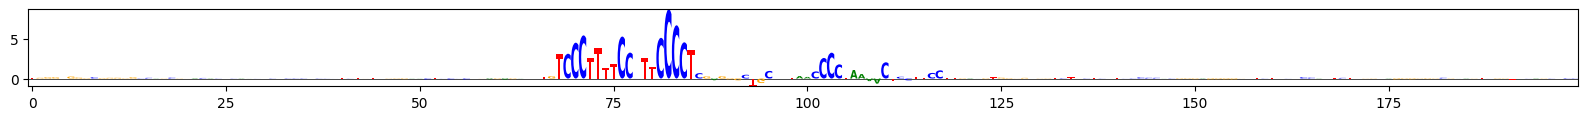

In [22]:
# get the pre-activated outputs
layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract a sequence from x_test
X = x_test[991:992]
print(X.shape)

#########################################################
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

# calculate saliency maps
saliency_map = calculate_saliency_map(X, layer)
print(saliency_map)
saliency_map = saliency_map.numpy()
# gradient correction
saliency_map -= np.mean(saliency_map, axis=2, keepdims=True)

#########################################################
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)
  
  # Save the saliency plot with the sequence index in the filename
  fig.savefig(f" HNRNPK_sal_map_seq991_baseline_cnn_exp.svg", dpi=300)